In [ ]:
import os
from random import randint

import cv2
import nibabel
import nibabel as nib
import numpy as np
import torch
from matplotlib import animation
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import imageio
import os
from PIL import Image
from torchvision import transforms
import pandas as pd
import random
from scipy import ndimage
import mat73

In [223]:
import cv2
import os

def save_image_as_png(image, folder_path, filename):
    # Create the folder if it doesn't exist
    os.makedirs(folder_path, exist_ok=True)
    # Convert the image to the appropriate data type and scale it to 8-bit range
    image = (image * 255).astype(np.uint8)
    # Convert the image array to PIL Image
    img = Image.fromarray(image)

    # Save the image as PNG
    file_path = os.path.join(folder_path, filename+'.png')
    img.save(file_path, "PNG")

class MRIDataset(Dataset):
    """Healthy and Anomaly MRI dataset."""

    def __init__(self, ROOT_DIR, transform=True, img_size=(32, 32), random_slice=False, is_anno = False, is_train = 'all'):
        """
        Args:
            ROOT_DIR (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.is_anno = is_anno
        self.transform = transforms.Compose(
                [transforms.ToPILImage(),
                 transforms.ToTensor()
                 ]
                ) if transform else False
        split_ratio = 0.5
        train_test_filenames = os.listdir(ROOT_DIR)
        
        random.shuffle(train_test_filenames)
        
        split_index = int(split_ratio * len(train_test_filenames))
        
        training_set = train_test_filenames[:split_index]
        testing_set = train_test_filenames[split_index:]
        if is_train == "all":
            self.filenames = train_test_filenames
        else:
            self.filenames = training_set if is_train else testing_set
        if ".DS_Store" in self.filenames:
            self.filenames.remove(".DS_Store")
        self.ROOT_DIR = ROOT_DIR
        self.random_slice = random_slice
        if is_anno:
            self.shp = (240, 240)
        else:
            self.shp = (256, 256)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # print(repr(idx))
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if os.path.exists(os.path.join(self.ROOT_DIR, self.filenames[idx], f"{self.filenames[idx]}.npy")):
            image = np.load(os.path.join(self.ROOT_DIR, self.filenames[idx], f"{self.filenames[idx]}.npy"))
            mask = np.zeros(image.shape)
            pass
        else:
            if self.is_anno:
                img_name = os.path.join(
                    self.ROOT_DIR, self.filenames[idx], f"{self.filenames[idx]}_flair.nii.gz"
                )
                img = nib.load(img_name)
                image = img.get_fdata()
                mask_name = os.path.join(
                    self.ROOT_DIR, self.filenames[idx], f"{self.filenames[idx]}_seg.nii.gz"
                )
                mask = nib.load(mask_name)
                mask = mask.get_fdata()
            else:
                img_name = os.path.join(
                    self.ROOT_DIR, self.filenames[idx], f"sub-{self.filenames[idx]}_ses-NFB3_T1w.nii.gz"
                )
                img = nib.load(img_name)
                image = img.get_fdata()                
                mask = torch.zeros(image.shape)
            
            image_mean = np.mean(image)
            image_std = np.std(image)
            img_range = (image_mean - 1 * image_std, image_mean + 2 * image_std)
            image = np.clip(image, img_range[0], img_range[1])
            image = image / (img_range[1] - img_range[0])
            image = torch.from_numpy(image).float()
            mask = torch.from_numpy(mask).float()
#             np.save(
#                     os.path.join(self.ROOT_DIR, self.filenames[idx], f"{self.filenames[idx]}.npy"), image.astype(
#                             np.float32
#                             )
#                     )
        
        if self.random_slice:
            # slice_idx = randint(32, 122)
            slice_idx = randint(40, 100)
        else:
            slice_idx = 120
        image = image[:, slice_idx:slice_idx + 1, :].reshape(256, 192).astype(np.float32)
        mask = mask[:, slice_idx:slice_idx + 1, :].reshape(256, 192).astype(np.float32)        

#         image =image[:, :, slice_idx:slice_idx + 1].reshape(self.shp)
# #         .reshape(self.shp).astype(np.float32)
#         mask = mask[:, :, slice_idx:slice_idx + 1].reshape(self.shp)
#         .reshape(self.shp).astype(np.float32)          
        save_image_as_png(image, path_save, self.filenames[idx])
        label = 1 if mask.max()>0 else 0
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        sample = {'image': image, "filenames": self.filenames[idx], "mask": mask, "label" : label}
        return sample

In [ ]:
path_save = r"C:\Users\Admin\Dropbox\PC\Documents\Anomaly Detection\AnoDDPM\DATASETS\brainMRI\train\good1"

In [225]:
ROOT_DIR = './'

In [226]:
args = {
  "img_size": [
    256,
    256
  ],
  "Batch_Size": 1,
  "EPOCHS": 4000,
  "T": 1000,
  "base_channels": 128,
  "beta_schedule": "linear",
  "channel_mults": "",
  "loss-type": "l2",
  "loss_weight": "none",
  "train_start": True,
  "lr": 1e-4,
  "random_slice": True,
  "sample_distance": 800,
  "weight_decay": 0.0,
  "save_imgs": False,
  "save_vids": True,
  "dropout": 0,
  "attention_resolutions": "16,8",
  "num_heads": 2,
  "num_head_channels": -1,
  "noise_fn": "simplex",
  "dataset": "mri"
}

In [ ]:
training_dataset = MRIDataset(
        # ROOT_DIR=f'{ROOT_DIR}DATASETS/brain/MRIs', img_size=args['img_size'], random_slice=args['random_slice']
        ROOT_DIR=f'C:\Users\MSI\Downloads\NFBS_Dataset\NFBS_Dataset', img_size=args['img_size'], random_slice=args['random_slice']
        )
testing_dataset = MRIDataset(
        ROOT_DIR=f'{ROOT_DIR}DATASETS/Test/', img_size=args['img_size'], random_slice=args['random_slice']
        )

In [228]:
len(training_dataset.filenames)

125

In [229]:
import matplotlib.pyplot as plt

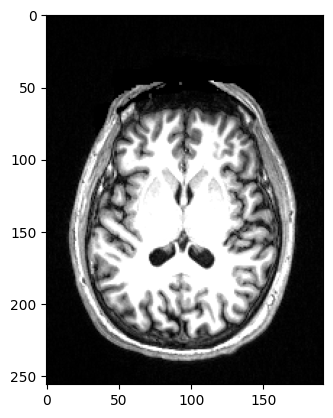

In [230]:
plt.imshow(i['image'][0], cmap= 'gray')

In [231]:
# len(training_dataset)

In [232]:
for i in training_dataset:
    print(i['image'].shape)

torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([1, 256, 192])
torch.Size([